<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico 2 </font></h1>
    <h2><font style="bold">Visión por Computadora 1 - CEIA </font></h2>
    <h3><font style="bold">Abril Noguera - Pablo Brahim - Kevin Pennington</font></h3>
</div>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

## Parte 1

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
- Medición sobre todo el frame.
- Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.

**Detector de Máximo Enfoque en Video**

1. Convertir cada frame a escala de grises
2. Calcular la métrica de enfoque (FM): Aplicar la Transformada de Fourier al frame para obtener su espectro de frecuencias, y contar cuántas componentes tienen valores altos (consideradas como detalles o bordes). Cuanto más alto el valor FM, mayor la nitidez.
3. Repetir la métrica en tres regiones distintas
    - En todo el frame.
    - En una región central que ocupe el 5% del área total.
    - En una región central que ocupe el 10% del área total.
4. Identificar el frame más nítido: Buscar el frame con el valor máximo en cada una de las listas. Ese frame representa el momento de mayor enfoque según esa métrica.

In [3]:
def calculate_fm(image):
    # FFT y centrado
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude = np.abs(fshift)

    # Umbral
    M = np.max(magnitude)
    threshold = M / 1000

    # Conteo de componentes de alta frecuencia
    high_freq_count = np.sum(magnitude > threshold)
    total_pixels = image.size

    # Métrica FM
    fm = high_freq_count / total_pixels
    return fm

def get_center_roi(image, percent=5):
    h, w = image.shape
    area = h * w
    roi_area = int(area * (percent / 100))
    side = int(np.sqrt(roi_area))
    cx, cy = w // 2, h // 2
    x1 = max(cx - side // 2, 0)
    y1 = max(cy - side // 2, 0)
    return image[y1:y1+side, x1:x1+side]


In [5]:
# Abrir video
cap = cv2.VideoCapture("focus_video.mov")
fm_full, fm_roi5, fm_roi10 = [], [], []
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Métricas
    fm_full.append(calculate_fm(gray))
    fm_roi5.append(calculate_fm(get_center_roi(gray, percent=5)))
    fm_roi10.append(calculate_fm(get_center_roi(gray, percent=10)))
    frame_count += 1

cap.release()

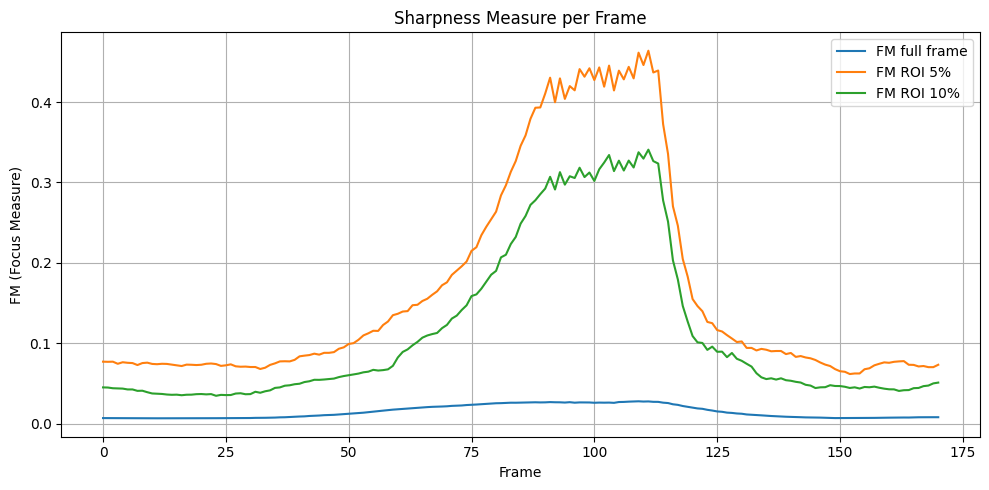

In [6]:
# Graficar resultados
plt.figure(figsize=(10,5))
plt.plot(fm_full, label="FM full frame")
plt.plot(fm_roi5, label="FM ROI 5%")
plt.plot(fm_roi10, label="FM ROI 10%")
plt.xlabel("Frame")
plt.ylabel("FM (Focus Measure)")
plt.title("Sharpness Measure per Frame")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Mostrar el frame con mejor enfoque
print(f"Frame con mayor enfoque (Full Frame): {np.argmax(fm_full)}")
print(f"Frame con mayor enfoque (ROI 5%): {np.argmax(fm_roi5)}")
print(f"Frame con mayor enfoque (ROI 10%): {np.argmax(fm_roi10)}")

Frame con mayor enfoque (Full Frame): 109
Frame con mayor enfoque (ROI 5%): 111
Frame con mayor enfoque (ROI 10%): 111


## Opcional:
1. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [5]:
# MÉTRICAS DE ENFOQUE

def fm_metric(region):
    """Focus Measure (FM) en dominio frecuencia"""
    f = np.fft.fft2(region)
    fshift = np.fft.fftshift(f)
    af = np.abs(fshift)
    m = np.max(af)
    thres = m / 1000
    return np.sum(af > thres) / af.size

def lapv_metric(region):
    """LAPV - Varianza del Laplaciano"""
    lap = cv2.Laplacian(region, cv2.CV_64F)
    return lap.var()

In [6]:
# UTILIDADES DE PROCESAMIENTO

def dividir_en_grilla(imagen, N, M):
    """Divide imagen en NxM regiones"""
    h, w = imagen.shape
    grid_h, grid_w = h // N, w // M
    regiones = []
    for i in range(N):
        for j in range(M):
            region = imagen[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            regiones.append(region)
    return regiones

def procesar_video(video_path, N, M, metrica_fn, max_frames=None):
    """Calcula la métrica por región y frame"""
    cap = cv2.VideoCapture(video_path)
    regiones_series = [[] for _ in range(N * M)]
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret or (max_frames and frame_count >= max_frames):
            break
        gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        regiones = dividir_en_grilla(gris, N, M)
        for idx, region in enumerate(regiones):
            valor = metrica_fn(region)
            regiones_series[idx].append(valor)
        frame_count += 1

    cap.release()
    return regiones_series

def graficar_curvas(regiones_series, N, M, titulo):
    plt.figure(figsize=(12, 6))
    for idx, serie in enumerate(regiones_series):
        plt.plot(serie, label=f'Región {idx}')
    plt.title(titulo)
    plt.xlabel("Frame")
    plt.ylabel("Métrica de Enfoque")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def detectar_maximos(regiones_series, N, M):
    print("📌 Frame de máximo enfoque por región:")
    for idx, serie in enumerate(regiones_series):
        frame_max = np.argmax(serie)
        print(f" - Región {idx} ({idx//M}, {idx%M}): Frame {frame_max}")

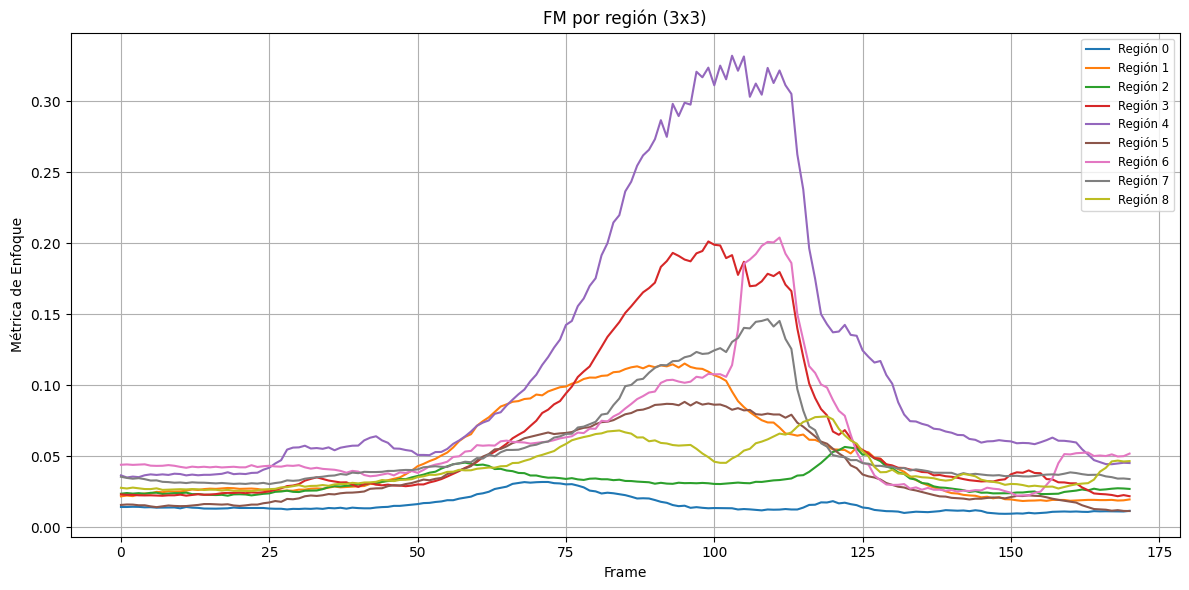

📌 Frame de máximo enfoque por región:
 - Región 0 (0, 0): Frame 71
 - Región 1 (0, 1): Frame 95
 - Región 2 (0, 2): Frame 122
 - Región 3 (1, 0): Frame 99
 - Región 4 (1, 1): Frame 103
 - Región 5 (1, 2): Frame 95
 - Región 6 (2, 0): Frame 111
 - Región 7 (2, 1): Frame 109
 - Región 8 (2, 2): Frame 119


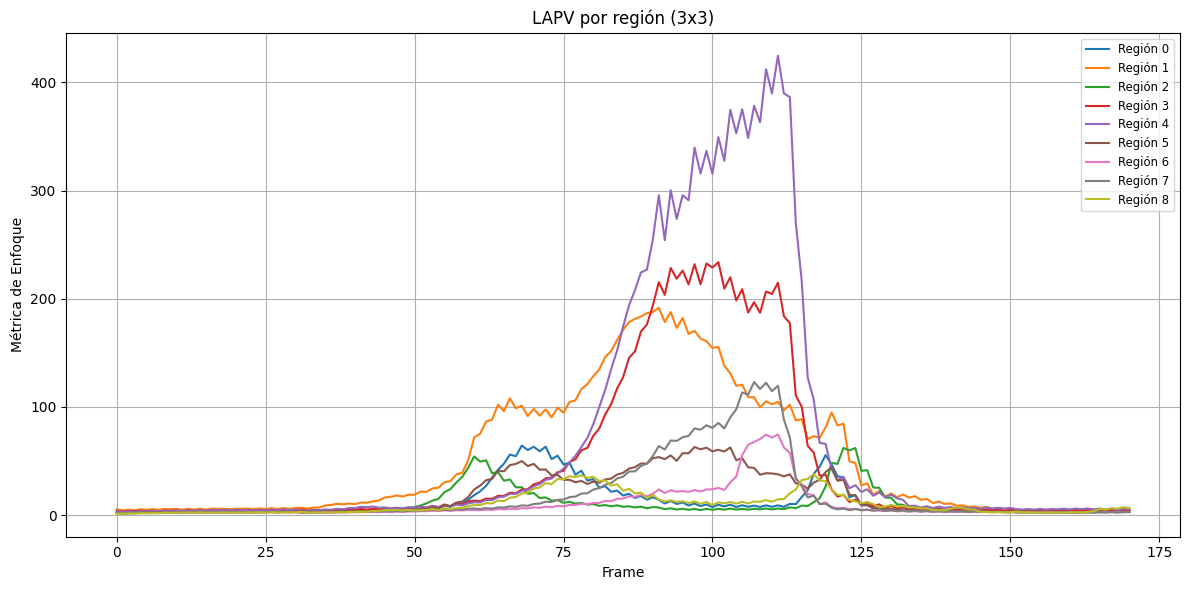

📌 Frame de máximo enfoque por región:
 - Región 0 (0, 0): Frame 68
 - Región 1 (0, 1): Frame 91
 - Región 2 (0, 2): Frame 122
 - Región 3 (1, 0): Frame 101
 - Región 4 (1, 1): Frame 111
 - Región 5 (1, 2): Frame 97
 - Región 6 (2, 0): Frame 111
 - Región 7 (2, 1): Frame 107
 - Región 8 (2, 2): Frame 117


In [ ]:
video = "focus_video.mov"

# Configuración de grilla
N, M = 3, 3

# FM
fm_series = procesar_video(video, N, M, fm_metric)
graficar_curvas(fm_series, N, M, f"FM por región ({N}x{M})")
detectar_maximos(fm_series, N, M)

# LAPV
lapv_series = procesar_video(video, N, M, lapv_metric)
graficar_curvas(lapv_series, N, M, f"LAPV por región ({N}x{M})")
detectar_maximos(lapv_series, N, M)